# Clasificación de Alzheimer mediante MRI
Red neuronal para clasificar imágenes de MRI en 4 clases diferentes de Alzheimer:
•	No Demencia
•	Demencia Muy Leve
•	Demencia Leve
•	Demencia Moderada

El modelo tiene como objetivo clasificar imágenes de MRI del cerebro a través de una red neuronal convolucional, útil para detectar cuatro etapas de demencia en el cribado de la enfermedad de Alzheimer.


In [1]:
# Libraries importation
import os # operating system interfaces
from os.path import join
from glob import glob
import numpy as np # scientific computing
import pandas as pd # data analysis
import tensorflow as tf
import matplotlib.pyplot as plt # plots
import PIL # image files manipulation
import random

# callback to reduce learning rate
from tensorflow.keras.callbacks import ReduceLROnPlateau

# opencv to handle images (https://opencv.org/releases/)
import cv2 as cv

# print metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, \
    confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.18.0


##### **Valores constantes**

En esta parte, se establecen cuatro parámetros:

- **AUTOTUNE:** controla la optimización de la potencia de cálculo.
- **TAMAÑO DEL LOTE (BATCH SIZE):** define el subconjunto de datos sobre el cual calcular el gradiente. Después de algunas ejecuciones, decidimos establecer el hiperparámetro en 32, también dependiendo de si el TPU está habilitado o no.
- **TAMAÑO DE LA IMAGEN (IMAGE SIZE):** define el tamaño de las imágenes que ingresan a la primera capa del modelo.
- **ÉPOCAS (EPOCHS):** establece el número máximo de épocas en las que entrenar el modelo.


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE # automatic paralleling computing
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 50 # reduced from 100 because of no significant improvement after 50th epoch

In [4]:
import pandas as pd
from glob import glob
from os.path import join
import os

# Obtener la ruta actual del script
current_dir = os.getcwd()
print("Directorio actual:", current_dir)

# Definir la ruta base - ajusta esto según donde esté tu notebook en relación a la carpeta AlzCare-AI
data_folder = "../data/tomography_images"  # Si estás en la raíz del proyecto
# O alternativamente:
#data_folder = "data/tomography_images"  # Si estás dentro de la carpeta AlzCare-AI

# Verificar si las carpetas existen
print("\nVerificando rutas:")
print(f"Ruta completa: {os.path.abspath(data_folder)}")
print(f"¿Existe la carpeta base? {os.path.exists(data_folder)}")
for category in ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]:
    full_path = join(data_folder, category)
    print(f"¿Existe {category}? {os.path.exists(full_path)}")

# Resto del código igual, pero añadimos verificación de patrones de archivo
for category in ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]:
    pattern = join(data_folder, category, "*")
    files = glob(pattern)
    print(f"\nArchivos encontrados en {category}: {len(files)}")
    if len(files) > 0:
        print(f"Primer archivo encontrado: {files[0]}")

Directorio actual: c:\F5_Proyectos\AlzCare-AI\AlzCare-AI\AlzCare-AI\notebooks

Verificando rutas:
Ruta completa: c:\F5_Proyectos\AlzCare-AI\AlzCare-AI\AlzCare-AI\data\tomography_images
¿Existe la carpeta base? True
¿Existe MildDemented? True
¿Existe ModerateDemented? True
¿Existe NonDemented? True
¿Existe VeryMildDemented? True

Archivos encontrados en MildDemented: 896
Primer archivo encontrado: ../data/tomography_images\MildDemented\1 (10).jpg

Archivos encontrados en ModerateDemented: 64
Primer archivo encontrado: ../data/tomography_images\ModerateDemented\1 (2).jpg

Archivos encontrados en NonDemented: 3200
Primer archivo encontrado: ../data/tomography_images\NonDemented\1 (10).jpg

Archivos encontrados en VeryMildDemented: 2240
Primer archivo encontrado: ../data/tomography_images\VeryMildDemented\1 (10).jpg


Dividir la imágenes en entrenamiento, validación y prueba

In [5]:
## Imágenes NonDemented
df_NonDemented_imgs = pd.DataFrame({
    "X": sorted(glob(join(data_folder, "NonDemented", "*"))),
    "y": 0,
    "class": "NonDementia"
})
shuffled_non = df_NonDemented_imgs.sample(frac=1)
testsize_non = int(0.2 * len(shuffled_non))

# Test
non_test = shuffled_non[:testsize_non]

# Train and validation
non_trainval = shuffled_non[testsize_non:]
trainsize_non = int(0.8 * len(non_trainval))

# Train
shuffled_non_train = non_trainval[:trainsize_non]

# Validation
shuffled_non_val = non_trainval[trainsize_non:]

## Imágenes VeryMildDemented
df_VeryMildDemented_imgs = pd.DataFrame({
    "X": sorted(glob(join(data_folder, "VeryMildDemented", "*"))),
    "y": 1,
    "class": "VeryMildDementia"
})
shuffled_verymild = df_VeryMildDemented_imgs.sample(frac=1)
testsize_verymild = int(0.2 * len(shuffled_verymild))

# Test
verymild_test = shuffled_verymild[:testsize_verymild]

# Train and validation
verymild_trainval = shuffled_verymild[testsize_verymild:]
trainsize_verymild = int(0.8 * len(verymild_trainval))

# Train
shuffled_verymild_train = verymild_trainval[:trainsize_verymild]

# Validation
shuffled_verymild_val = verymild_trainval[trainsize_verymild:]

## Imágenes MildDemented
df_MildDemented_imgs = pd.DataFrame({
    "X": sorted(glob(join(data_folder, "MildDemented", "*"))),
    "y": 2,
    "class": "MildDementia"
})
shuffled_mild = df_MildDemented_imgs.sample(frac=1)
testsize_mild = int(0.2 * len(shuffled_mild))

# Test
mild_test = shuffled_mild[:testsize_mild]

# Train and validation
mild_trainval = shuffled_mild[testsize_mild:]
trainsize_mild = int(0.8 * len(mild_trainval))

# Train
shuffled_mild_train = mild_trainval[:trainsize_mild]

# Validation
shuffled_mild_val = mild_trainval[trainsize_mild:]

## Imágenes ModerateDemented
df_ModerateDemented_imgs = pd.DataFrame({
    "X": sorted(glob(join(data_folder, "ModerateDemented", "*"))),
    "y": 3,
    "class": "ModerateDementia"
})
shuffled_moderate = df_ModerateDemented_imgs.sample(frac=1)
testsize_moderate = int(0.2 * len(shuffled_moderate))

# Test
moderate_test = shuffled_moderate[:testsize_moderate]

# Train and validation
moderate_trainval = shuffled_moderate[testsize_moderate:]
trainsize_moderate = int(0.8 * len(moderate_trainval))

# Train
shuffled_moderate_train = moderate_trainval[:trainsize_moderate]

# Validation
shuffled_moderate_val = moderate_trainval[trainsize_moderate:]


print("------------")
print("\nTest:")
print("# de imágenes NonDemented Alzheimer =", len(non_test))
print("# de imágenes VeryMildDemented Alzheimer =", len(verymild_test))
print("# de imágenes MildDemented Alzheimer =", len(mild_test))
print("# de imágenes ModerateDemented Alzheimer =", len(moderate_test))
print("------------")
print("\nEntrenamiento:")
print("# de imágenes NonDemented Alzheimer =", len(shuffled_non_train))
print("# de imágenes VeryMildDemented Alzheimer =", len(shuffled_verymild_train))
print("# de imágenes MildDemented Alzheimer =", len(shuffled_mild_train))
print("# de imágenes ModerateDemented Alzheimer =", len(shuffled_moderate_train))
print("------------")
print("\nValidación:")
print("# de imágenes NonDemented Alzheimer =", len(shuffled_non_val))
print("# de imágenes VeryMildDemented Alzheimer =", len(shuffled_verymild_val))
print("# de imágenes MildDemented Alzheimer =", len(shuffled_mild_val))
print("# de imágenes ModerateDemented Alzheimer =", len(shuffled_moderate_val))

------------

Test:
# de imágenes NonDemented Alzheimer = 640
# de imágenes VeryMildDemented Alzheimer = 448
# de imágenes MildDemented Alzheimer = 179
# de imágenes ModerateDemented Alzheimer = 12
------------

Entrenamiento:
# de imágenes NonDemented Alzheimer = 2048
# de imágenes VeryMildDemented Alzheimer = 1433
# de imágenes MildDemented Alzheimer = 573
# de imágenes ModerateDemented Alzheimer = 41
------------

Validación:
# de imágenes NonDemented Alzheimer = 512
# de imágenes VeryMildDemented Alzheimer = 359
# de imágenes MildDemented Alzheimer = 144
# de imágenes ModerateDemented Alzheimer = 11


Mostrar Desequilibrio de Clases

Histograma de la longitud del vector de objetos de las cuatro clases.


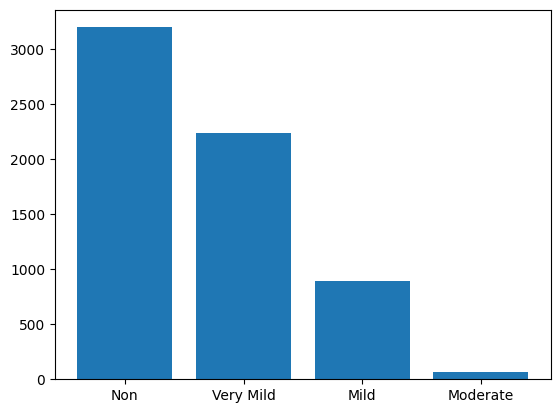

In [6]:
# show class imbalance in the dataset

heights = [len(shuffled_non), len(shuffled_verymild), len(shuffled_mild), len(shuffled_moderate)]

fig, ax = plt.subplots()
height = heights
bars = ('Non', 'Very Mild', 'Mild', 'Moderate')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()

**Ingeniería de Características**
Se cargan las imágenes y se crean los conjuntos de entrenamiento, validación y prueba "listos" para ser dados a las capas.

**Definición de funciones para cargar las imágenes y realizar la codificación one-hot**
- El método **load_image** se define para leer las rutas y cargar las imágenes directamente desde sus rutas, creadas en la sección anterior. El resultado final del método es, para cada ruta, la imagen en escala de grises, redimensionada según los parámetros definidos previamente, lista para ingresar en la primera capa de la red neuronal.
- El método **hot_array** realiza la codificación one-hot, generando cuatro versores normales para identificar las cuatro clases.


In [7]:
def load_image(fname):
    """
    Load an image using opencv given its path.
    """
    # img is a numpy array
    img = cv.imread(fname)
    # opencv uses BGR channel order by default
    # so convert to RGB
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # resize image
    resize = (IMAGE_SIZE[0], IMAGE_SIZE[1])
    img = cv.resize(img, resize)
    return img

def hot_array(class_number):
    ha = [0,0,0,0]
    ha[class_number] = 1
    return ha

**Concatenar conjunto de entrenamiento y conjunto de prueba**
Aquí se realiza la concatenación final, para obtener un conjunto de entrenamiento compuesto por imágenes de todas las clases. 
- **train_concat** contiene el 80% del 80% del total de imágenes para cada clase, porque el conjunto de entrenamiento se definió a partir del 80% del conjunto de entrenamiento + validación.
- **X**, que contiene todas las rutas de las imágenes, se le aplica el método **load_image** definido anteriormente. Posteriormente, también se concatenan las etiquetas y el resultado se convierte en un array. 
- Tanto las imágenes como las etiquetas se apilan en los vectores **xtrain** y **ytrain**.

In [8]:
## TRAIN SET
# concatenate
train_concat = pd.concat([shuffled_mild_train, shuffled_moderate_train, shuffled_non_train, shuffled_verymild_train])
# shuffle
train_concat = train_concat.sample(frac=1)
# load image
train_concat["X"] = train_concat["X"].apply(load_image)

# extract label before one hot in order to use for class weights
y_train_lab = train_concat["y"]
y_train_lab = np.array(y_train_lab) # convert into a numpy array

# apply one-hot encoding
train_concat["y"] = train_concat["y"].apply(hot_array)

# stack images and labels
xtrain = np.stack(train_concat["X"])
ytrain = np.stack(train_concat["y"])


## VALIDATION SET
val_concat = pd.concat([shuffled_mild_val, shuffled_moderate_val, shuffled_non_val, shuffled_verymild_val])
val_concat = val_concat.sample(frac=1)
val_concat["X"] = val_concat["X"].apply(load_image)
val_concat["y"] = val_concat["y"].apply(hot_array)
xval = np.stack(val_concat["X"])
yval = np.stack(val_concat["y"])


Visualizar los datos

Esta sección está destinada a visualizar algunas de las imágenes contenidas en todo el conjunto de datos. Es evidente que en cada clase están presentes diferentes secciones de la imagen de MRI del cerebro.


Text(0, 0.5, 'Moderate Dementia')

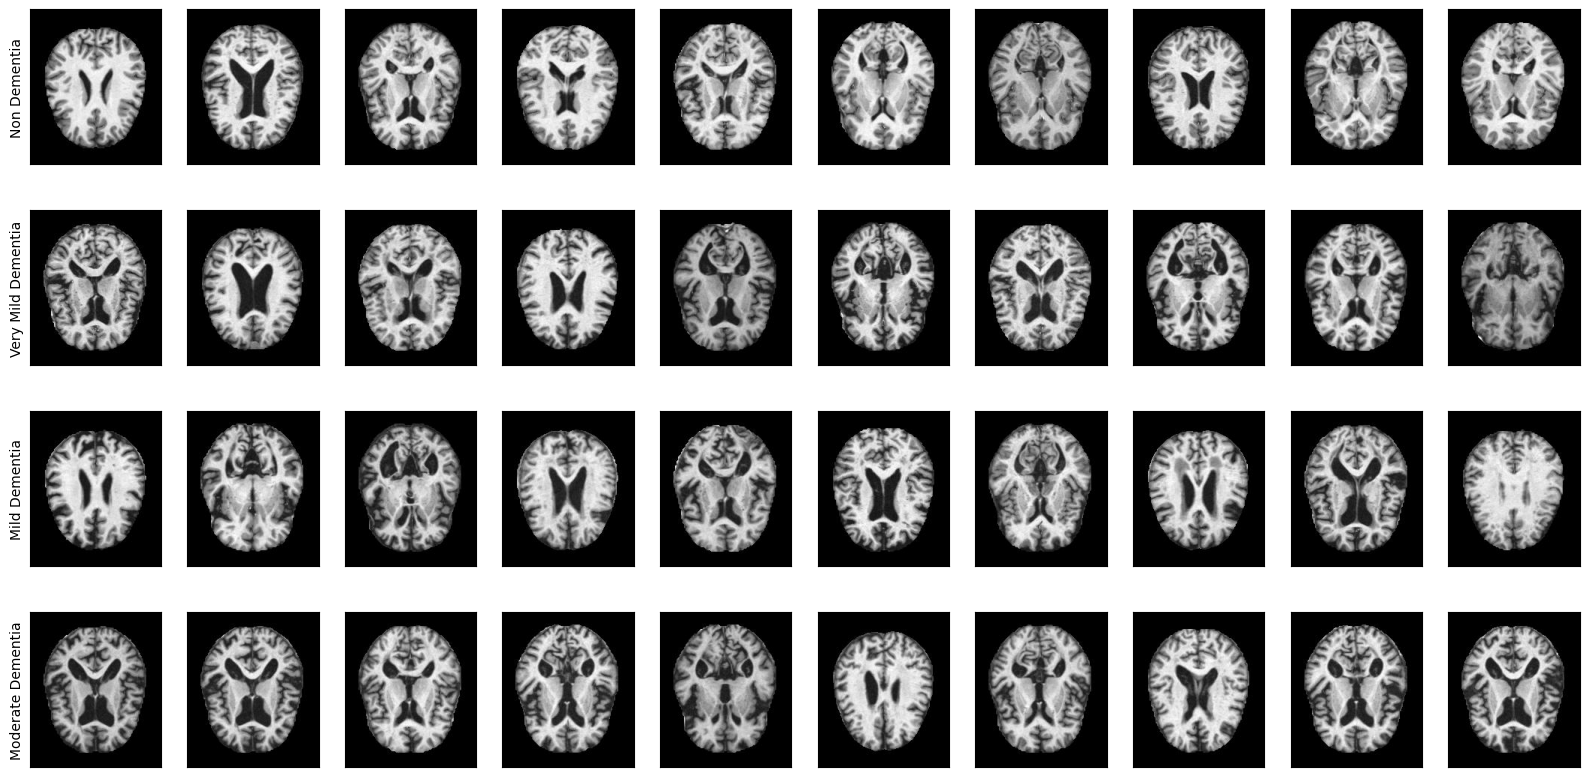

In [9]:
# plot some images per class

ncols = 10

fig, axs = plt.subplots(nrows=4, ncols=ncols, figsize=(20, 10))

for fname,ax in zip(shuffled_non.loc[:ncols, "X"], axs[0,:]):
    im = load_image(fname)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

for fname,ax in zip(shuffled_verymild.loc[:ncols, "X"], axs[1,:]):
    im = load_image(fname)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    
for fname,ax in zip(shuffled_mild.loc[:ncols, "X"], axs[2,:]):
    im = load_image(fname)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

for fname,ax in zip(shuffled_moderate.loc[:ncols, "X"], axs[3,:]):
    im = load_image(fname)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

axs[0,0].set_ylabel("Non Dementia")
axs[1,0].set_ylabel("Very Mild Dementia")
axs[2,0].set_ylabel("Mild Dementia")
axs[3,0].set_ylabel("Moderate Dementia")


**Construir el Modelo**
En estas líneas de código, se construye el modelo, ensamblando las diferentes capas.
- El método  ***conv_block*** utiliza el método *Sequential* proporcionado por la biblioteca Keras. En particular, en este bloque convolucional, se realizan dos convoluciones 2D separables, para ahorrar potencia de cálculo. 
- Ajustamos la función de activación de **relu** a **elu**, ya que es más efectiva en redes neuronales convolucionales que analizan imágenes. 
- Se añaden al bloque una capa de Normalización por Lotes y una capa de Max Pooling 2D.

- El método ***denseblock*** se define para construir el bloque completamente conectado, añadiendo una capa **Dense** (siempre con la función de activación elu), una capa de **Normalización por Lotes** y una capa de **Dropout**, útil para desactivar algunos nodos de la red a una tasa definida por el argumento dropoutrate.

El modelo actual se define en el método build_model:
- Se utiliza el método Sequential proporcionado por Keras para añadir las capas.
- Primero, se define la capa de entrada, como una imagen con el tamaño decidido al principio del código.
- Luego, se añaden dos convoluciones 2D separables (siempre con la función de activación elu), antes de la capa de Max Pooling 2D.
- Posteriormente, se aplican tres conv_block con un número creciente de filtros (32, 64, 128) antes de una capa de Dropout.
- Se aplica otro conv_block (con 256 filtros), luego otra capa de Dropout y una capa de Flatten.
- Tres dense_block (512, 128, 64 unidades) y una capa Dense concluyen la arquitectura del modelo

In [10]:
# Convolutional Block
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='elu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='elu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

# Dense Block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='elu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

# Function to build the model
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='elu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='elu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    return model


**Decidir una Métrica**
El desequilibrio entre el número de imágenes en cada clase nos impide usar la precisión. En su lugar, se ha utilizado el **ROC AUC**. Además, el optimizador **ADAM** con una tasa de aprendizaje inicial de 0.001 y la **Pérdida de Entropía Cruzada** se han definido respectivamente como optimizador y función de costo. Se llama al método build_model y el modelo se define como un objeto.


In [11]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        # choose Adam as the optimizer with initial learning rate = 0.001
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

Entrenamiento del Modelo - 1
Este pasaje contiene el uso de las siguientes funciones proporcionadas por Keras para establecer algunos parámetros del entrenamiento:
•	ModelCheckpoint: para guardar el mejor resultado del modelo durante las iteraciones y evitar perder los datos en ejecución.
•	EarlyStopping: para detener el entrenamiento si se logran resultados similares durante un número X de épocas consecutivas (paciencia).
•	ReduceLROnPlateau: para reducir la tasa de aprendizaje cuando el modelo no mejora en iteraciones consecutivas.
También se definen los pesos para las clases, dando más importancia a la clase con menos datos (es decir, Demencia Moderada). Este parámetro se utiliza luego en el ajuste del modelo.
La función fit toma como argumentos tanto hiperparámetros como parámetros, además de las devoluciones de llamada, los pesos de las clases y el conjunto de datos de entrenamiento y validación (imágenes y etiquetas). Una vez que se llama a este método, comienza el entrenamiento del modelo, para un número de épocas < 50, como se estableció al principio del código.
El argumento class_weights es lo que adoptamos para resolver el problema de los conjuntos de datos desequilibrados. En particular, intentamos realizar aumento de datos para la clase que contiene solo 64 imágenes, tanto en términos de volteo/rotación/corte como de contraste/brillo/escala de grises. Este procedimiento dio resultados pobres, observando el rendimiento general: esto se debió a que el modelo está construido para reconocer imágenes (conjunto de prueba) que están en el mismo formato (tamaño/contraste/ángulos) que las utilizadas en el conjunto de entrenamiento, por lo que una transformación de las imágenes no tiene un buen impacto en la evaluación final en el conjunto de prueba.


In [13]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "alzheimer_model.weights.h5",
    save_best_only=True,
    save_weights_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

# reduce the learning rate when there is a plateau and the model is not improving
reduce_lr = ReduceLROnPlateau(
    monitor='auc', 
    factor=0.5, 
    verbose=1, 
    mode="auto",
    cooldown=5, 
    patience=10, 
    min_lr=0.00001
)

# Adding class weights to compensate class imabalance
class_weights = { 0: 1,
                1: 1.5,
                2: 3,
                3: 20
}

# Fit the model
history = model.fit(
    xtrain, ytrain, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr], 
    validation_data=(xval, yval), 
    class_weight = class_weights
)


Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 72s 566ms/step - auc: 0.6772 - loss: 2.3115 - val_auc: 0.7578 - val_loss: 1.2384 - learning_rate: 0.0010
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 74s 580ms/step - auc: 0.7072 - loss: 2.1514 - val_auc: 0.7620 - val_loss: 1.2847 - learning_rate: 0.0010
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 79s 616ms/step - auc: 0.7326 - loss: 2.0206 - val_auc: 0.7909 - val_loss: 1.5855 - learning_rate: 0.0010
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 643ms/step - auc: 0.7569 - loss: 1.9535 - val_auc: 0.7909 - val_loss: 1.9830 - learning_rate: 0.0010
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 96s 748ms/step - auc: 0.7759 - loss: 1.7118 - val_auc: 0.8133 - val_loss: 1.6581 - learning_rate: 0.0010
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 79s 615ms/step - auc: 0.8138 - loss: 1.4801 - val_auc: 0.7402 - val_loss: 1.1703 - learning_rate: 0.0010
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 77s 599ms/step - auc: 0.8339 - loss: 1.4096 - val_auc: 0.9023 - val_loss: 0.7211 - learnin

**Visualizar Métricas del Modelo y Evolución de la Tasa de Aprendizaje**

Los tres gráficos muestran respectivamente la tendencia del AUC, la Función de Pérdida y la Tasa de Aprendizaje a lo largo de las épocas de entrenamiento. Podemos notar una gran mejora en comparación con el modelo inicial.

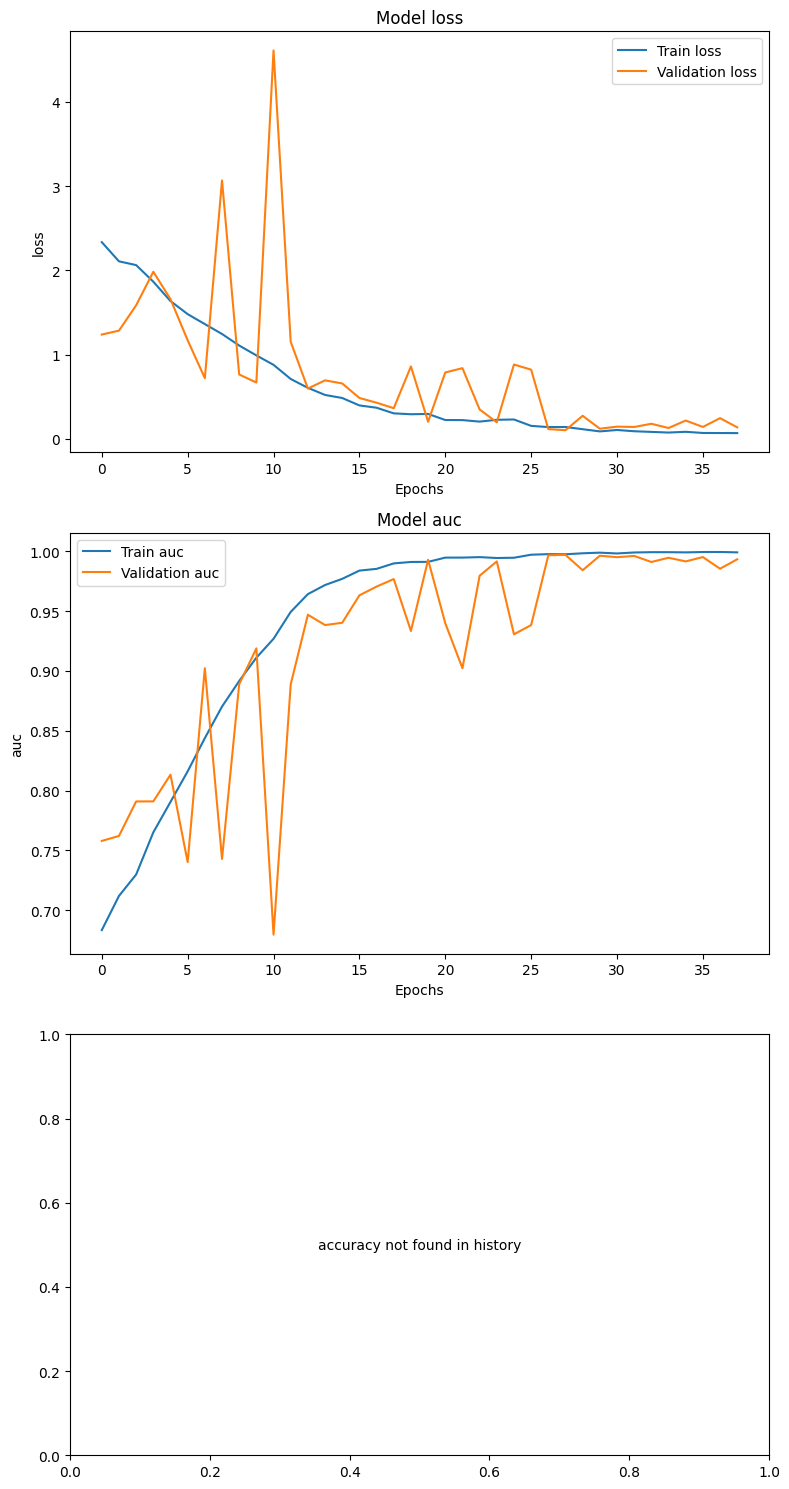

In [14]:
metrics = ['loss', 'auc', 'accuracy']  # Ajusta según las métricas usadas
fig, ax = plt.subplots(len(metrics), 1, figsize=(8, 15))

for i, met in enumerate(metrics):
    if met in history.history:
        ax[i].plot(history.history[met], label=f'Train {met}')
        ax[i].plot(history.history[f'val_{met}'], label=f'Validation {met}')
        ax[i].set_title(f'Model {met}')
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(met)
        ax[i].legend()
    else:
        ax[i].text(0.5, 0.5, f'{met} not found in history',
                horizontalalignment='center', verticalalignment='center',
                transform=ax[i].transAxes)

plt.tight_layout()
plt.show()


**Evaluar el Modelo**

En esta sección, el modelo evalúa los datos previamente guardados en el conjunto de prueba. 
- Primero, se sigue el mismo procedimiento de concatenación realizado anteriormente para el conjunto de entrenamiento y validación, para obtener dos vectores de objetos xtest y ytest necesarios para evaluar el modelo. La evaluación utiliza el método evaluate. 
- La función de pérdida y el AUC muestran valores excelentes.


In [15]:
## TEST SET
test_concat = pd.concat([mild_test, moderate_test, non_test, verymild_test])
test_concat = test_concat.sample(frac=1)
test_concat["X"] = test_concat["X"].apply(load_image)
test_concat["y"] = test_concat["y"].apply(hot_array)
xtest = np.stack(val_concat["X"])
ytest = np.stack(val_concat["y"])

In [16]:
# evaluation
_ = model.evaluate(xtest,ytest)

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - auc: 0.9966 - loss: 0.1112


In [17]:
# Function from Federico Agostini notebooks (slightly modified)

def print_metrics(model, X, y, cm_labels="auto"):
    """
    Print the following metrics: accuracy, balanced accuracy, precision, recall, f1.
    If the model is able to predict probabilities, also auc is calculated.
    Moreover, the confusion matrix is plotted.

    Parameters
    ----------
    model : sklearn estimator
        Sklearn estimator or similar which implements the method `predict`
        and optionally `predict_proba`.
    X : array like
        Input features.
    y : array like
        Target labels.
    cm_labels : list [default="auto"]
        Optional labels to be used in the confusion matrix.

    Returns
    -------
    metrics : dict
        Dictionary with the calculated metrics.

    """
    y_pred = model.predict(X)
    y_pred = np.squeeze(y_pred)
    y_pred = np.argmax(y_pred,1).astype(int)

    metrics = {
        "Accuracy"    : accuracy_score(y, y_pred),
        "Bal Accuracy": balanced_accuracy_score(y, y_pred),
        "Precision"   : precision_score(y, y_pred, average="macro"),
        "Recall"      : recall_score(y, y_pred, average="macro"),
        "f1"          : f1_score(y, y_pred, average="macro")
    }
    # add AUC if the classifier is able to predict probabilities
    try:
        y_pred_proba = model.predict_proba(X)
        metrics["AUC"] = roc_auc_score(y, y_pred_proba, multi_class="ovr", average="macro")
    except:
        metrics["AUC"] = np.nan
    
    for k,v in metrics.items():
        print("{:12s} = {}".format(k,v))  
    print("\n")
    
    # confusion matrix
    cm = confusion_matrix(y, y_pred, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    sns.heatmap(cm, ax=ax, square=True, vmin=0, vmax=1, annot=True, 
                linewidths=.05, fmt=".2f", cbar_kws={"shrink":.8}, 
                xticklabels=cm_labels, yticklabels=cm_labels)
    plt.xticks([0.5, 1.5, 2.5, 3.5], ['Non', 'Very Mild', 'Mild', 'Moderate'])
    plt.yticks([0.5, 1.5, 2.5, 3.5], ['Non', 'Very Mild', 'Mild', 'Moderate'])
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")

    metrics["cm"] = cm

    return metrics


33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step
Accuracy     = 0.9649122807017544
Bal Accuracy = 0.9695258699899412
Precision    = 0.9771666108242977
Recall       = 0.9695258699899412
f1           = 0.9731793803388575
AUC          = nan




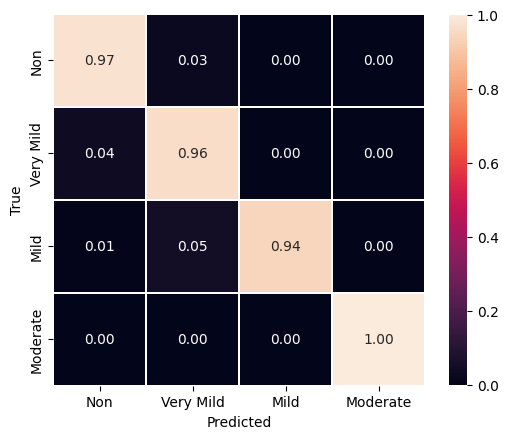

In [18]:
# visualize model metrics
y_test = ytest.argmax(axis=1)
met = print_metrics(model, xtest, y_test)